In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
import precision_recall_cutoff


### defining bucket###
s3=boto3.resource('s3')
bucket_name= 'dmw-448'
bucket = s3.Bucket(bucket_name)


file_key = 'turnover.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
## Changing sales to dummy variables
turnover = pd.concat([turnover.drop(columns = ['sales'], axis = 1), pd.get_dummies(turnover['sales'])], axis = 1)

## Changing salary to dummy variables
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [4]:


## Creating interactions/features from the decision tree
turnover['interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & (turnover['last_evaluation'] <= 0.575), 1, 0)
turnover['interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] >= 2.5) & (turnover['satisfaction_level'] >= 0.115), 1, 0)
turnover['interaction_3'] = np.where((turnover['satisfaction_level'] >= 0.465) & (turnover['time_spend_company'] <= 4.5) & (turnover['average_montly_hours'] <= 290.5), 1, 0)

turnover.head()



,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


In [9]:
## Defining the input and target variables
X = turnover.drop(columns = ['left', 'salary'], axis = 1)
Y = turnover['left']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [10]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
4947,0.57,0.60,4,248,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
954,0.40,0.46,2,131,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1088,0.91,0.90,4,250,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
6376,0.62,0.91,5,267,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
6357,0.16,0.82,5,121,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


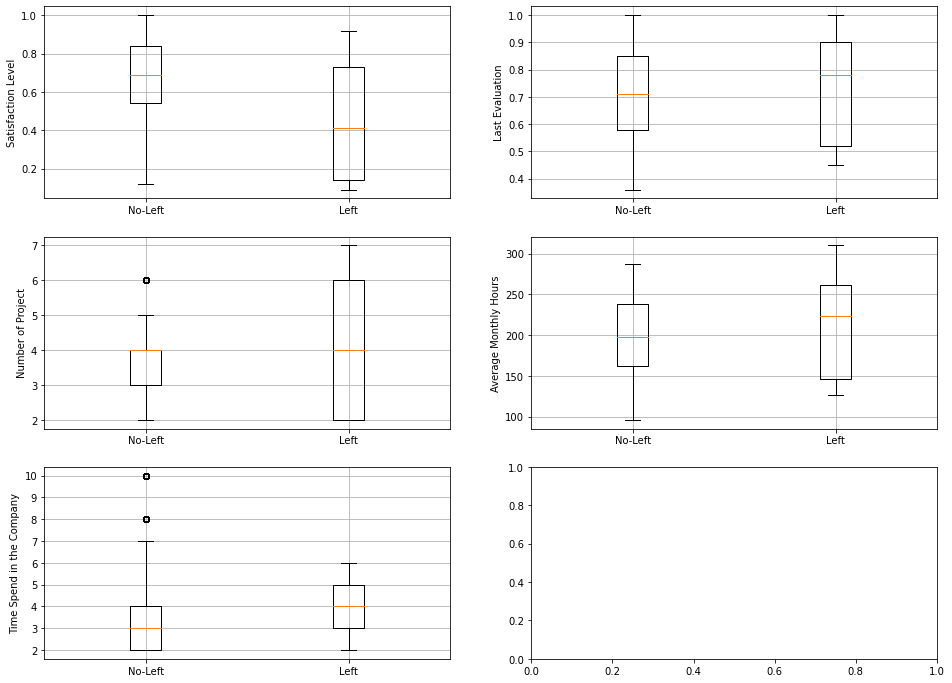

In [11]:
turnover_train = pd.concat([X_train, Y_train], axis = 1)

## Creating a new figure
fig, axes = plt.subplots(3, 2, figsize = (16, 12))

## Subsetting the data 
left = turnover_train[turnover_train['left'] == 1]
no_left = turnover_train[turnover_train['left'] == 0]

axes[0, 0].boxplot([no_left['satisfaction_level'], left['satisfaction_level']], labels = ['No-Left', 'Left'])
axes[0, 0].set_ylabel('Satisfaction Level')
axes[0, 0].grid()

axes[0, 1].boxplot([no_left['last_evaluation'], left['last_evaluation']], labels = ['No-Left', 'Left'])
axes[0, 1].set_ylabel('Last Evaluation')
axes[0, 1].grid()

axes[1, 0].boxplot([no_left['number_project'], left['number_project']], labels = ['No-Left', 'Left'])
axes[1, 0].set_ylabel('Number of Project')
axes[1, 0].grid()

axes[1, 1].boxplot([no_left['average_montly_hours'], left['average_montly_hours']], labels = ['No-Left', 'Left'])
axes[1, 1].set_ylabel('Average Monthly Hours')
axes[1, 1].grid()

axes[2, 0].boxplot([no_left['time_spend_company'], left['time_spend_company']], labels = ['No-Left', 'Left'])
axes[2, 0].set_ylabel('Time Spend in the Company')
axes[2, 0].grid()

In [12]:
pd.crosstab(turnover_train['Work_accident'], turnover_train['left'], normalize = 'index')

left,0,1
Work_accident,,
0,0.735157,0.264843
1,0.921159,0.078841


In [13]:
pd.crosstab(turnover_train['promotion_last_5years'], turnover_train['left'], normalize = 'index')

left,0,1
promotion_last_5years,,
0,0.757860,0.242140
1,0.942748,0.057252


In [14]:
pd.crosstab(turnover_train['IT'], turnover_train['left'], normalize = 'index')

left,0,1
IT,,
0,0.761235,0.238765
1,0.769309,0.230691


In [15]:
pd.crosstab(turnover_train['RandD'], turnover_train['left'], normalize = 'index')

left,0,1
RandD,,
0,0.757115,0.242885
1,0.850407,0.149593


In [16]:
pd.crosstab(turnover_train['accounting'], turnover_train['left'], normalize = 'index')

left,0,1
accounting,,
0,0.763156,0.236844
1,0.738636,0.261364


In [18]:
pd.crosstab(turnover_train['hr'], turnover_train['left'], normalize = 'index')

left,0,1
hr,,
0,0.764824,0.235176
1,0.704467,0.295533


In [19]:
pd.crosstab(turnover_train['management'], turnover_train['left'], normalize = 'index')

left,0,1
management,,
0,0.757613,0.242387
1,0.859406,0.140594


In [20]:
pd.crosstab(turnover_train['marketing'], turnover_train['left'], normalize = 'index')

left,0,1
marketing,,
0,0.761989,0.238011
1,0.760402,0.239598


In [21]:
pd.crosstab(turnover_train['product_mng'], turnover_train['left'], normalize = 'index')

left,0,1
product_mng,,
0,0.760912,0.239088
1,0.777166,0.222834


In [22]:
pd.crosstab(turnover_train['sales'], turnover_train['left'], normalize = 'index')

left,0,1
sales,,
0,0.763886,0.236114
1,0.756700,0.243300


In [23]:
pd.crosstab(turnover_train['support'], turnover_train['left'], normalize = 'index')

left,0,1
support,,
0,0.763882,0.236118
1,0.750559,0.249441


In [24]:
pd.crosstab(turnover_train['technical'], turnover_train['left'], normalize = 'index')

left,0,1
technical,,
0,0.765531,0.234469
1,0.745379,0.254621


In [25]:
pd.crosstab(turnover_train['high'], turnover_train['left'], normalize = 'index')

left,0,1
high,,
0,0.747209,0.252791
1,0.926680,0.073320


In [27]:
pd.crosstab(turnover_train['low'], turnover_train['left'], normalize = 'index')

left,0,1
low,,
0,0.815320,0.184680
1,0.705499,0.294501


In [28]:
pd.crosstab(turnover_train['medium'], turnover_train['left'], normalize = 'index')

left,0,1
medium,,
0,0.737352,0.262648
1,0.794208,0.205792


In [29]:
pd.crosstab(turnover_train['interaction_1'], turnover_train['left'], normalize = 'index')

left,0,1
interaction_1,,
0,0.847152,0.152848
1,0.053530,0.946470


In [30]:
pd.crosstab(turnover_train['interaction_2'], turnover_train['left'], normalize = 'index')

left,0,1
interaction_2,,
0,0.743659,0.256341
1,0.920712,0.079288


In [31]:
pd.crosstab(turnover_train['interaction_3'], turnover_train['left'], normalize = 'index')

left,0,1
interaction_3,,
0,0.441069,0.558931
1,0.986263,0.013737


In [32]:
## Defining the input and target variables
X_train = X_train[['satisfaction_level', 'average_montly_hours', 'time_spend_company', 
                   'high', 'interaction_1', 'interaction_2', 'interaction_3']]
X_test = X_test[['satisfaction_level', 'average_montly_hours', 'time_spend_company', 
                 'high', 'interaction_1', 'interaction_2', 'interaction_3']]
                 
## Random forest with top 7
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on test
RF_pred = RF.predict_proba(X_test)[:, 1]

## Predicting the labels
RF_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, RF_pred)

## Computing the classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2286
           1       0.89      0.92      0.91       714

    accuracy                           0.96      3000
   macro avg       0.93      0.94      0.94      3000
weighted avg       0.96      0.96      0.96      3000



In [33]:
# AdaBoost model 
Ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), 
                         n_estimators = 500, 
                         learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on test
Ada_pred = Ada.predict_proba(X_test)[:, 1]

## Predicting the labels
Ada_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, Ada_pred)

## Computing the classification report
print(classification_report(Y_test, Ada_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2286
           1       0.96      0.94      0.95       714

    accuracy                           0.98      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



## based on my results i would Adaboost